In [ ]:
import os
import sys
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToTensor, Compose, ConvertImageDtype
import torch.nn.functional as F

from Data_manager import MaskRCNNDataset, mask_collate_fn

In [2]:
print(torch.version.cuda)

12.9


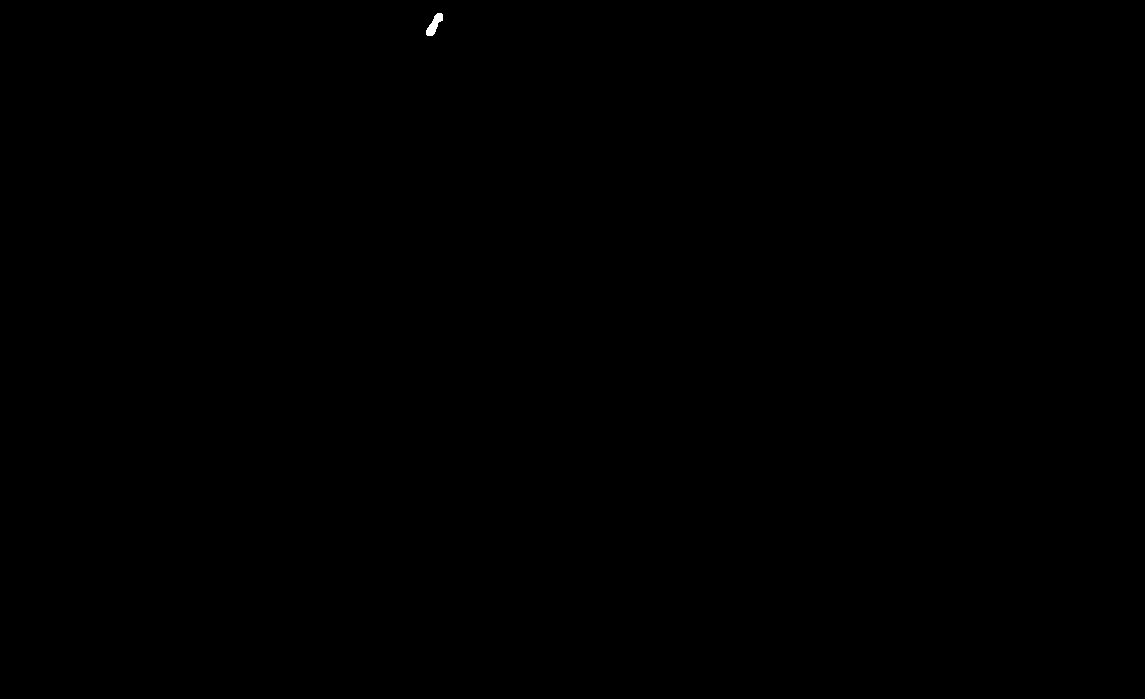

In [3]:
mask = Image.open('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g/labels/7.png')
mask.show()

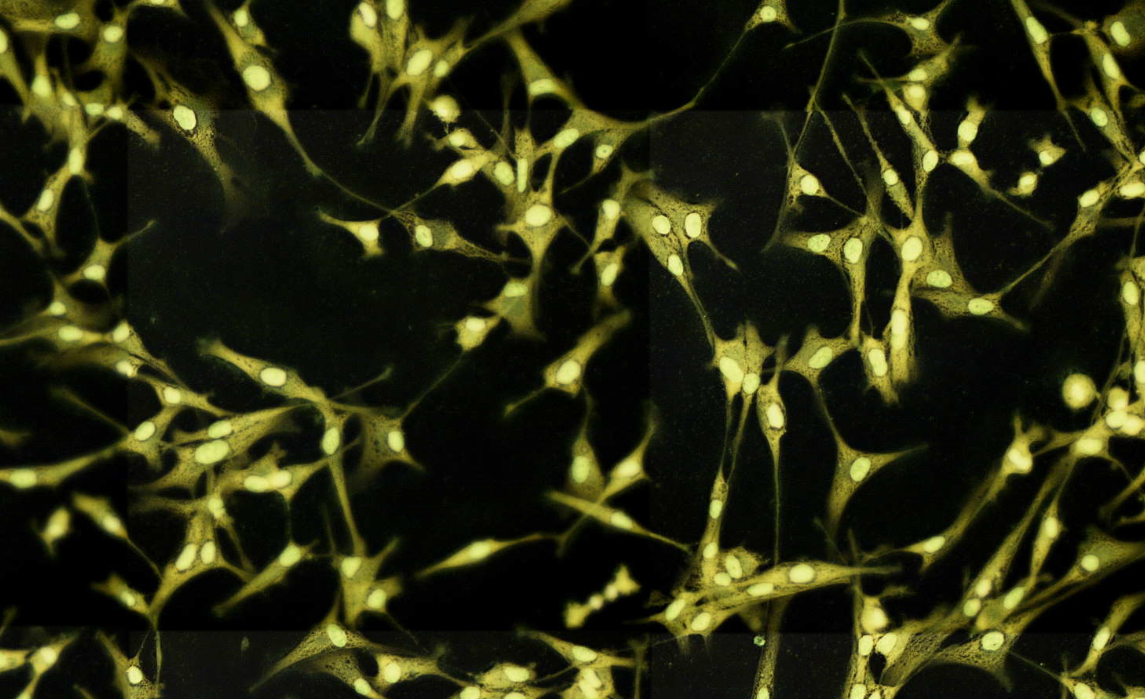

In [4]:
image = Image.open('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g6.tif')
image.show()

In [5]:
labels_dir = '../data/Control_u87m6_5_g_neg/u87m6_5_k_g/labels'
transform = Compose([ToTensor(), ConvertImageDtype(torch.float)])
mask_files = sorted(os.listdir(labels_dir), key=lambda x: int(x.split('.')[0]))
masks = []
for mf in mask_files:
    mask_path = os.path.join(labels_dir, mf)
    mask = Image.open(mask_path) #.convert('L')
    # mask.show()
    masks.append(mask)
mask_tensors = []
boxes = []
for mask in masks:
    mask_tensor = transform(mask) 
    mask_tensor = (mask_tensor > 0).float() 
            
    if mask_tensor.sum() == 0: 
        continue
    y_indices, x_indices = torch.nonzero(mask_tensor[0] > 0, as_tuple=True)
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    boxes.append([x_min.item(), y_min.item(), x_max.item() + 1, y_max.item() + 1])  # [xmin, ymin, xmax, ymax]
            
    mask_tensors.append(mask_tensor)  


print(len(boxes))

219


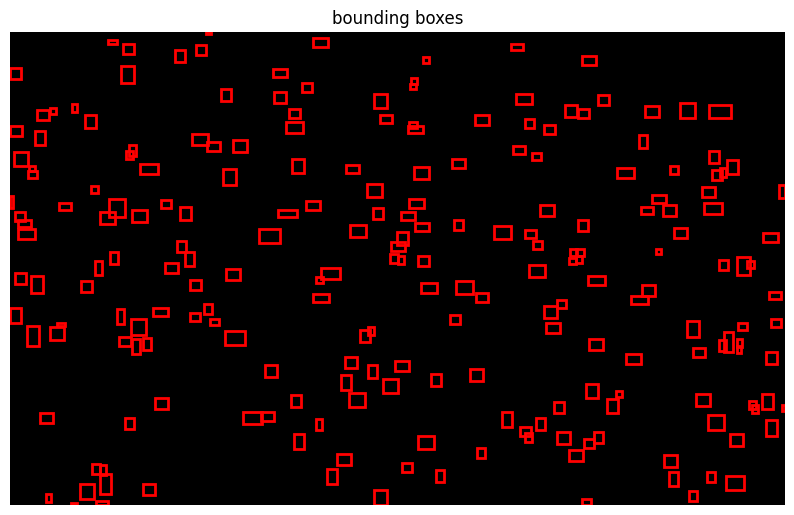

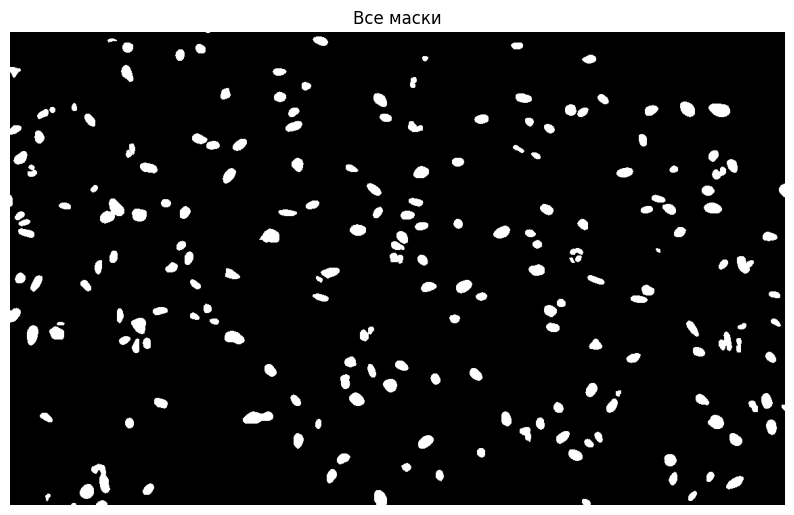

In [6]:
# test
H, W = mask_tensors[0].shape[1], mask_tensors[0].shape[2] 


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
black_bg = np.zeros((H, W, 3))  
ax.imshow(black_bg) 

for box in boxes:
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("bounding boxes")
ax.axis('off')  
plt.show()

all_masks_sum = torch.sum(torch.stack(mask_tensors), dim=0).squeeze(0).numpy()  
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(all_masks_sum, cmap='gray')  
ax.set_title("Все маски")
ax.axis('off')
plt.show()


In [ ]:
train_root_dir = '../data/Hesperidine_u87m6_5_10_g_neg'
train_dataset = MaskRCNNDataset(train_root_dir)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn = mask_collate_fn)

valid_root_dir = '../data/Control_u87m6_5_g_neg'
valid_dataset = MaskRCNNDataset(valid_root_dir)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn = mask_collate_fn)

In [8]:
len(valid_loader)

15

In [9]:
len(train_loader)

33

In [ ]:
device = 'cuda'
num_epochs = 25
num_classes = 3
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=hidden_layer, dim_reduced=hidden_layer, num_classes=num_classes)

model.to(device)

In [11]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [12]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, targets = batch
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Обучение
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")
    
    # Валидация
    model.train() 
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, targets = batch
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")
    
    scheduler.step()

Epoch 1/25: 100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


Epoch [1/25], Train Loss: 1.4757


Validation Epoch 1/25: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Epoch [1/25], Val Loss: 0.8105


Epoch 2/25: 100%|██████████| 33/33 [00:34<00:00,  1.04s/it]


Epoch [2/25], Train Loss: 0.8217


Validation Epoch 2/25: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch [2/25], Val Loss: 0.7960


Epoch 3/25: 100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


Epoch [3/25], Train Loss: 0.7165


Validation Epoch 3/25: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Epoch [3/25], Val Loss: 0.6757


Epoch 4/25: 100%|██████████| 33/33 [00:35<00:00,  1.06s/it]


Epoch [4/25], Train Loss: 0.6637


Validation Epoch 4/25: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


Epoch [4/25], Val Loss: 0.6683


Epoch 5/25: 100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


Epoch [5/25], Train Loss: 0.6455


Validation Epoch 5/25: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch [5/25], Val Loss: 0.6554


Epoch 6/25: 100%|██████████| 33/33 [00:36<00:00,  1.12s/it]


Epoch [6/25], Train Loss: 0.6519


Validation Epoch 6/25: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch [6/25], Val Loss: 0.6487


Epoch 7/25: 100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


Epoch [7/25], Train Loss: 0.6377


Validation Epoch 7/25: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Epoch [7/25], Val Loss: 0.6588


Epoch 8/25: 100%|██████████| 33/33 [00:37<00:00,  1.13s/it]


Epoch [8/25], Train Loss: 0.6428


Validation Epoch 8/25: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


Epoch [8/25], Val Loss: 0.6582


Epoch 9/25: 100%|██████████| 33/33 [00:37<00:00,  1.14s/it]


Epoch [9/25], Train Loss: 0.6498


Validation Epoch 9/25: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch [9/25], Val Loss: 0.6448


Epoch 10/25: 100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


Epoch [10/25], Train Loss: 0.6434


Validation Epoch 10/25: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch [10/25], Val Loss: 0.6463


Epoch 11/25: 100%|██████████| 33/33 [00:34<00:00,  1.05s/it]


Epoch [11/25], Train Loss: 0.6307


Validation Epoch 11/25: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch [11/25], Val Loss: 0.6599


Epoch 12/25: 100%|██████████| 33/33 [00:37<00:00,  1.13s/it]


Epoch [12/25], Train Loss: 0.6259


Validation Epoch 12/25: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


Epoch [12/25], Val Loss: 0.6402


Epoch 13/25: 100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


Epoch [13/25], Train Loss: 0.6406


Validation Epoch 13/25: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


Epoch [13/25], Val Loss: 0.6403


Epoch 14/25: 100%|██████████| 33/33 [00:34<00:00,  1.05s/it]


Epoch [14/25], Train Loss: 0.6417


Validation Epoch 14/25: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


Epoch [14/25], Val Loss: 0.6464


Epoch 15/25: 100%|██████████| 33/33 [00:35<00:00,  1.07s/it]


Epoch [15/25], Train Loss: 0.6550


Validation Epoch 15/25: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


Epoch [15/25], Val Loss: 0.6534


Epoch 16/25: 100%|██████████| 33/33 [00:33<00:00,  1.01s/it]


Epoch [16/25], Train Loss: 0.6428


Validation Epoch 16/25: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


Epoch [16/25], Val Loss: 0.6518


Epoch 17/25: 100%|██████████| 33/33 [00:33<00:00,  1.02s/it]


Epoch [17/25], Train Loss: 0.6411


Validation Epoch 17/25: 100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


Epoch [17/25], Val Loss: 0.6619


Epoch 18/25: 100%|██████████| 33/33 [00:33<00:00,  1.02s/it]


Epoch [18/25], Train Loss: 0.6431


Validation Epoch 18/25: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


Epoch [18/25], Val Loss: 0.6613


Epoch 19/25: 100%|██████████| 33/33 [00:33<00:00,  1.01s/it]


Epoch [19/25], Train Loss: 0.6496


Validation Epoch 19/25: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch [19/25], Val Loss: 0.6502


Epoch 20/25: 100%|██████████| 33/33 [00:35<00:00,  1.07s/it]


Epoch [20/25], Train Loss: 0.6445


Validation Epoch 20/25: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


Epoch [20/25], Val Loss: 0.6556


Epoch 21/25: 100%|██████████| 33/33 [00:36<00:00,  1.12s/it]


Epoch [21/25], Train Loss: 0.6442


Validation Epoch 21/25: 100%|██████████| 15/15 [00:09<00:00,  1.67it/s]


Epoch [21/25], Val Loss: 0.6415


Epoch 22/25: 100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


Epoch [22/25], Train Loss: 0.6434


Validation Epoch 22/25: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


Epoch [22/25], Val Loss: 0.6400


Epoch 23/25: 100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


Epoch [23/25], Train Loss: 0.6434


Validation Epoch 23/25: 100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epoch [23/25], Val Loss: 0.6489


Epoch 24/25: 100%|██████████| 33/33 [00:35<00:00,  1.08s/it]


Epoch [24/25], Train Loss: 0.6394


Validation Epoch 24/25: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch [24/25], Val Loss: 0.6553


Epoch 25/25: 100%|██████████| 33/33 [00:36<00:00,  1.10s/it]


Epoch [25/25], Train Loss: 0.6442


Validation Epoch 25/25: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]

Epoch [25/25], Val Loss: 0.6533


In [ ]:
# train_losses = [1.4756587400580898, 0.8217112801291726, 0.7165061163179802, 0.6636899131717104, 0.645452978033008, 0.6519268913702532, 0.6376912873802763, 0.642753415035479, 0.6498193650534658, 0.6433846661538789, 0.6306558341690989, 0.6258593472567472, 0.6405845627640233, 0.6416629607027228, 0.6549802187717322, 0.6428265923803503, 0.6410629731236082, 0.6430845459302267, 0.6496207605708729, 0.6444839844197938, 0.6442109635381987, 0.6433917807810234, 0.6434001778111313, 0.6393992268677914, 0.6442327987064015]


In [ ]:
# val_losses = [0.8105309685071309, 0.795963176091512, 0.6757086396217347, 0.6683217088381449, 0.6554469664891561, 0.6486938198407491, 0.6587509830792745, 0.6582305034001669, 0.6447886904080709, 0.6463489532470703, 0.6598559737205505, 0.6401790380477905, 0.6402595996856689, 0.6464001218477885, 0.6533783992131551, 0.6518285115559895, 0.6619373202323914, 0.6613343159357706, 0.650204849243164, 0.6555777589480082, 0.6415329456329346, 0.6399871587753296, 0.6489090164502461, 0.6553272644678751, 0.653343923886617]

In [ ]:
# num_epochs = 25

In [7]:
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Val Loss': val_losses
})
fig = px.line(df, x='Epoch', y=['Train Loss', 'Val Loss'], title='Training and Validation Loss Curves')
fig.show()

In [17]:
torch.save(model.state_dict(), '../trained/test_mask_rcnn.pth')
print("Модель сохранена как test_mask_rcnn.pth")

Модель сохранена как test_mask_rcnn.pth


# TEST

In [8]:
def visualize_prediction(image, prediction, threshold=0.5):
    image = image.permute(1, 2, 0).cpu().numpy()  
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    
    for box, label, score, mask in zip(prediction['boxes'], prediction['labels'], prediction['scores'], prediction['masks']):
        if score > threshold:

            rect = patches.Rectangle((box[0].item(), box[1].item()), box[2].item() - box[0].item(), box[3].item() - box[1].item(),
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            # ax.text(box[0].item(), box[1].item() - 5, f'{label}',
            #         color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
            
            mask = mask[0].cpu().numpy()
            mask = np.ma.masked_where(mask <= 0.5, mask)
            ax.imshow(mask, alpha=1.0, cmap='jet')
    
    plt.axis('off')
    plt.show()

In [9]:
labels_dir = '../data/Control_u87m6_5_g_neg/u87m6_5_k_g/labels'
transform = Compose([ToTensor(), ConvertImageDtype(torch.float)])
mask_files = sorted(os.listdir(labels_dir), key=lambda x: int(x.split('.')[0]))
masks = []
for mf in mask_files:
    mask_path = os.path.join(labels_dir, mf)
    mask = Image.open(mask_path) #.convert('L')
    # mask.show()
    masks.append(mask)
mask_tensors = []
boxes = []
for mask in masks:
    mask_tensor = transform(mask) 
    mask_tensor = (mask_tensor > 0).float() 
            
    if mask_tensor.sum() == 0: 
        continue
    y_indices, x_indices = torch.nonzero(mask_tensor[0] > 0, as_tuple=True)
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    boxes.append([x_min.item(), y_min.item(), x_max.item() + 1, y_max.item() + 1])  # [xmin, ymin, xmax, ymax]
            
    mask_tensors.append(mask_tensor)  


print(len(boxes))

219


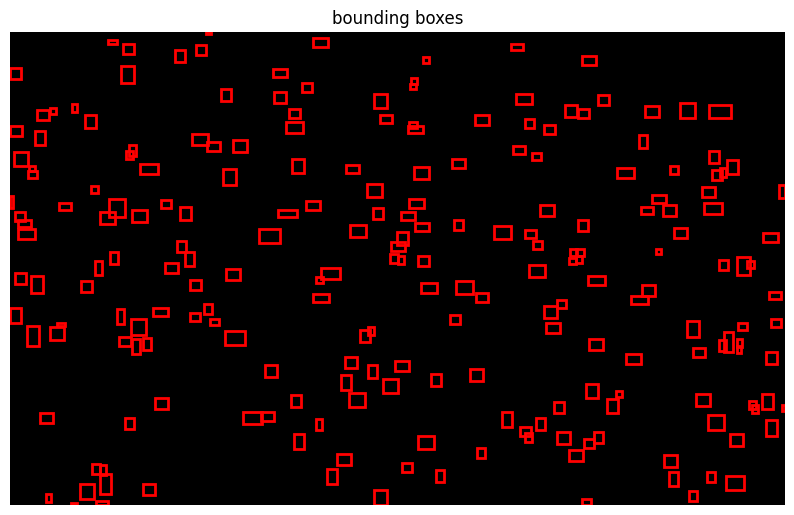

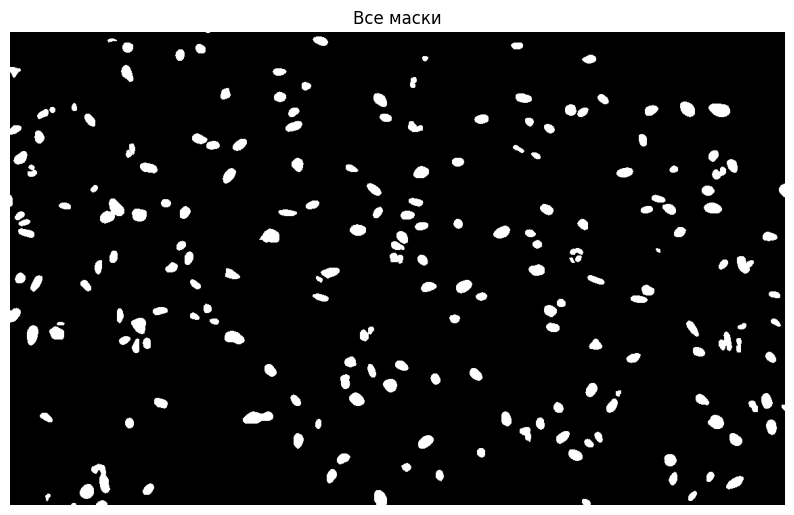

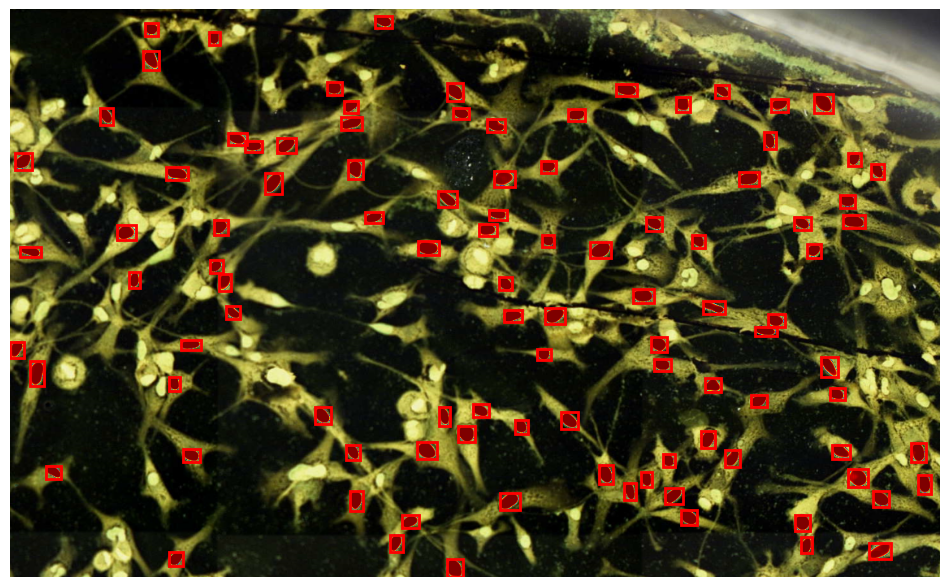

In [10]:
H, W = mask_tensors[0].shape[1], mask_tensors[0].shape[2] 


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
black_bg = np.zeros((H, W, 3))  
ax.imshow(black_bg) 

for box in boxes:
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("bounding boxes")
ax.axis('off')  
plt.show()

all_masks_sum = torch.sum(torch.stack(mask_tensors), dim=0).squeeze(0).numpy()  
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(all_masks_sum, cmap='gray')  
ax.set_title("Все маски")
ax.axis('off')
plt.show()

device = 'cuda'
num_classes = 3
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=None)  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=hidden_layer, dim_reduced=hidden_layer, num_classes=num_classes)

model.load_state_dict(torch.load('../trained/test_mask_rcnn.pth'))
model.to(device)
model.eval()

img_path = '../data/Control_u87m6_5_g_neg/u87m6_5_k_g.tif'
transform = Compose([ToTensor(), ConvertImageDtype(torch.float)])
image = Image.open(img_path).convert("RGB")
image_tensor = transform(image).to(device)

with torch.no_grad():
    pred = model([image_tensor])[0]

visualize_prediction(image_tensor, pred)

In [ ]:
# center_csv = os.path.join('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g/primary/u87m6_5_k_g_Center.csv')
# size_roundness_csv = os.path.join('../data/Hesperidine_u87m6_5_10_g_neg/u87m6_5_k_g/primary/u87m6_5_k_g_size_roundness.csv')
        
# info = pd.concat([pd.read_csv(center_csv, names=['x', 'y']), pd.read_csv(size_roundness_csv, names=['size', 'roundness'])], axis = 1)
# info['classes'] = info['size'].apply(lambda x: 1 if x <= 40 else 2)
# info